# Challenge

Pick a dataset of your choice with a binary outcome and the potential for at least 15 features.

Engineer your features, then create 3 models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach):

- Vanilla logistic regression
- Ridge logistic regression
- Lasso logistic regression

If you're stuck on how to begin combining your 2 new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline

df = pd.read_csv('./data/abalone.csv', names=["sex", "length", "diameter", "height", "whole weight", "shucked weight", "viscera weight", "shell weight", "rings"])

df.head()

low = df[df.rings <= 9].rings.sum()
med = df[df.rings > 9][df.rings < 12].rings.sum()
high = df[df.rings >= 12].rings.sum()

print('Low:', low, '\nMed:', med, '\nHigh:', high)

def set_rings_categ(num_rings):
    if num_rings <= 9:
        return 'low'
    elif num_rings > 9 and num_rings < 12:
        return 'med'
    else:
        return 'high'

df['rings'] = [set_rings_categ(num_rings) for num_rings in df['rings']]
df.head()

Low: 15887 
Med: 11697 
High: 13909


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,high
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,low
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,low
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,med
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,low


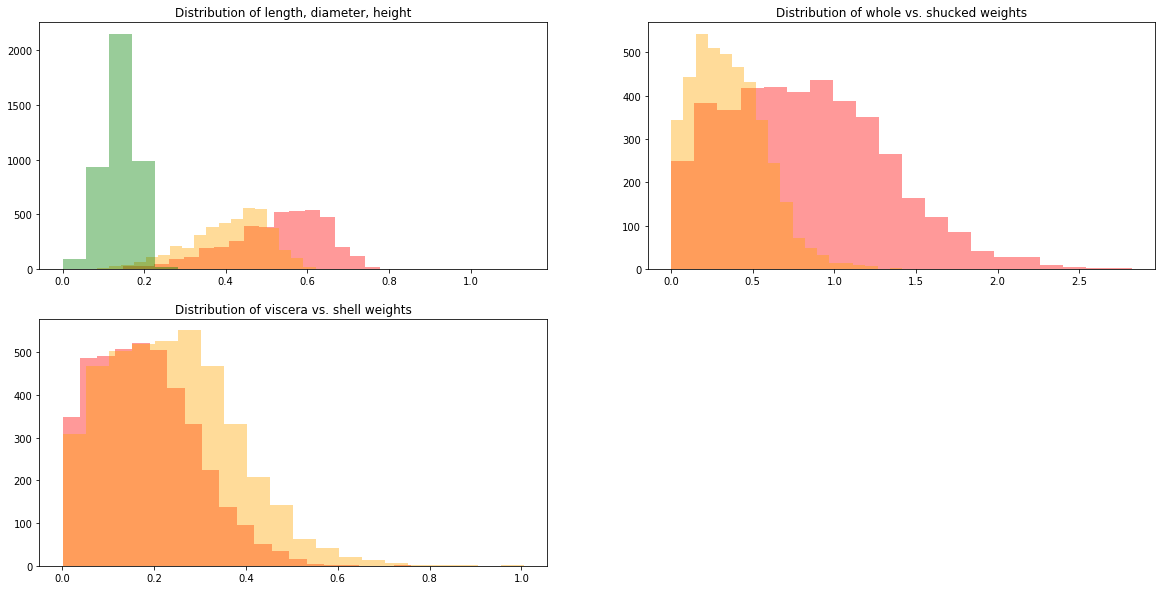

In [2]:
def make_hists(df):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.title('Distribution of length, diameter, height')
    plt.hist(df['length'], bins=20, color='red', alpha=0.4)
    plt.hist(df['diameter'], bins=20, color='orange', alpha=0.4)
    plt.hist(df['height'], bins=20, color='green', alpha=0.4)

    plt.subplot(2, 2, 2)
    plt.title('Distribution of whole vs. shucked weights')
    plt.hist(df['whole weight'], bins=20, color='red', alpha=0.4)
    plt.hist(df['shucked weight'], bins=20, color='orange', alpha=0.4)

    plt.subplot(2, 2, 3)
    plt.title('Distribution of viscera vs. shell weights')
    plt.hist(df['viscera weight'], bins=20, color='red', alpha=0.4)
    plt.hist(df['shell weight'], bins=20, color='orange', alpha=0.4)

#     plt.subplot(2, 2, 4)
#     plt.title('Distribution of rings')
#     plt.hist(df['rings'], bins=20)

    plt.show()

make_hists(df)

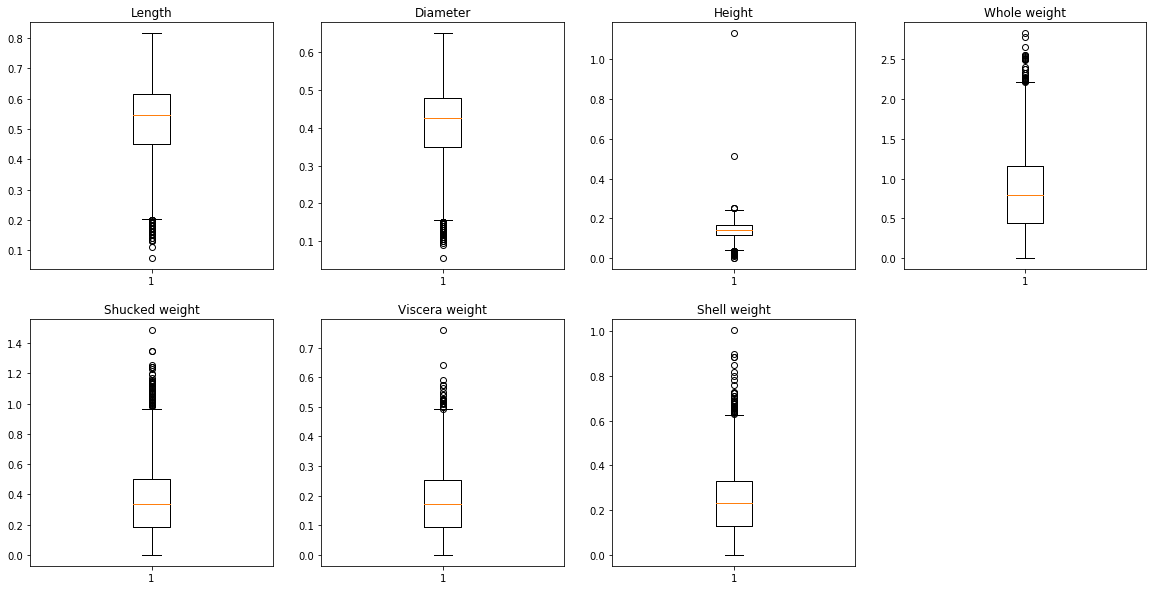

In [3]:
def make_boxplots(df):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.title('Length')
    plt.boxplot(df['length'])

    plt.subplot(2, 4, 2)
    plt.title('Diameter')
    plt.boxplot(df['diameter'])

    plt.subplot(2, 4, 3)
    plt.title('Height')
    plt.boxplot(df['height'])

    plt.subplot(2, 4, 4)
    plt.title('Whole weight')
    plt.boxplot(df['whole weight'])

    plt.subplot(2, 4, 5)
    plt.title('Shucked weight')
    plt.boxplot(df['shucked weight'])

    plt.subplot(2, 4, 6)
    plt.title('Viscera weight')
    plt.boxplot(df['viscera weight'])

    plt.subplot(2, 4, 7)
    plt.title('Shell weight')
    plt.boxplot(df['shell weight'])

#     plt.subplot(2, 4, 8)
#     plt.title('Rings')
#     plt.boxplot(df['rings'])

    plt.show()

make_boxplots(df)

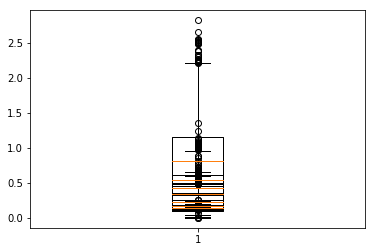

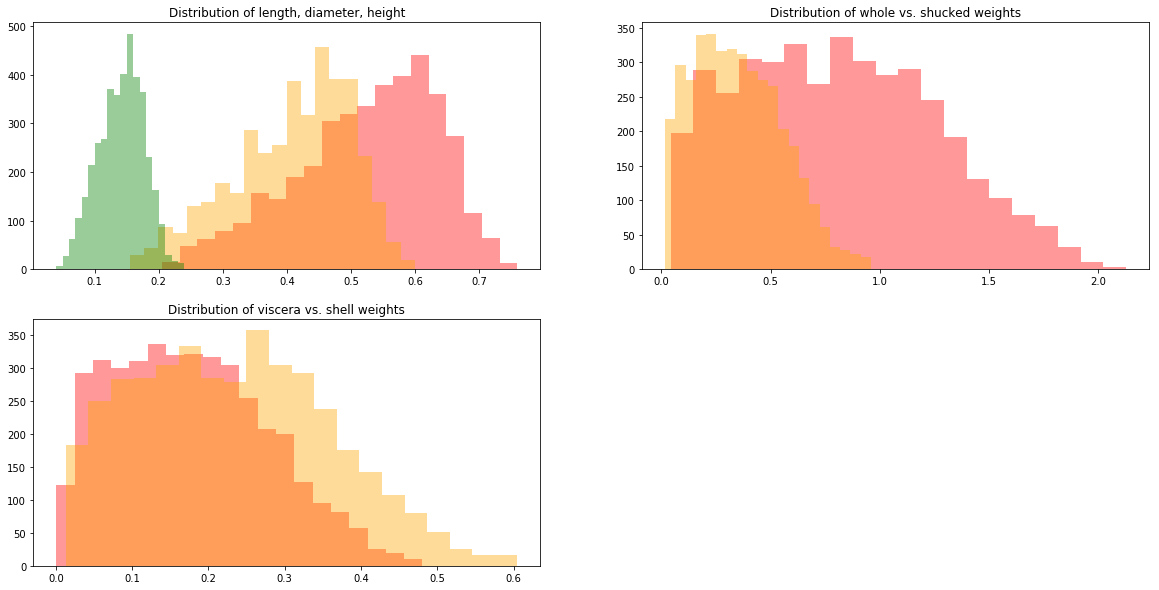

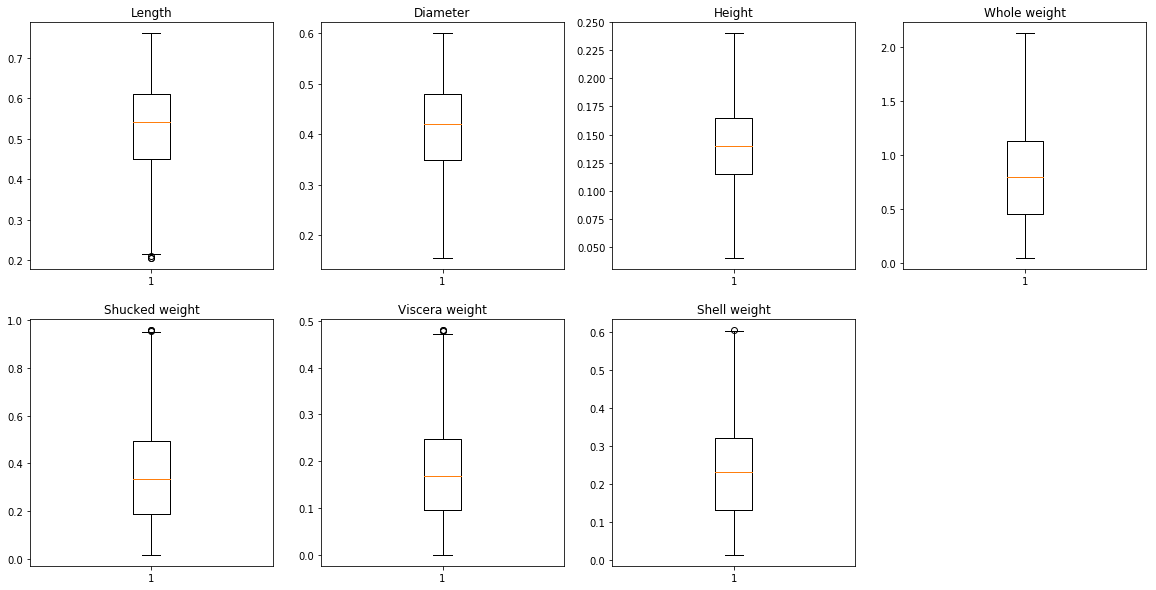

In [4]:
# remove all outliers for following features
features_to_remove_outliers_from = ['length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight']

for feature in features_to_remove_outliers_from:
    min_max_vals = [item.get_ydata()[1] for item in plt.boxplot(df[feature])['whiskers']]
    
    # remove outliers for that feature
    df = df[df[feature] >= min_max_vals[0]] 
    df = df[df[feature] <= min_max_vals[1]] 

make_hists(df)
make_boxplots(df)

In [5]:
# quadratic features
df['h ^ 2']  = df['height'] ** 2
# df['area'] = 3.14 * (df['diameter'] / 2) ** 2
# df['circumference'] = 3.14 * df['diameter']
# df['l ^ 2']  = df['length'] ** 2
# df['d ^ 2']  = df['diameter'] ** 2

# To make weight distributions a little more normally distributed
df['log shell weight'] = np.log(df['shell weight'])
# df['log whole weight'] = np.log(df['whole weight'])
# df['log shucked weight'] = np.log(df['shucked weight'])
# df['log viscera weight'] = np.log(df['viscera weight'])

# Standardize data (except sexes)
all_sexes = df['sex']
all_rings = df['rings']
names = list(df.columns)
names.remove('rings')
names.remove('sex')
df = pd.DataFrame(preprocessing.scale(df[names]), columns=names)
df['sex'] = all_sexes

# Make dummies out of sex
df = pd.get_dummies(df)

df['rings'] = all_rings.values

df.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,h ^ 2,log shell weight,sex_F,sex_I,sex_M,rings
0,-0.629270,-0.471317,-1.239055,-0.663994,-0.628821,-0.752883,-0.663601,-1.183498,-0.344186,0,0,1,high
1,-1.579519,-1.561270,-1.379567,-1.312302,-1.250822,-1.274624,-1.299868,-1.277975,-1.419881,0,0,1,low
2,0.049478,0.128157,-0.114952,-0.297706,-0.469589,-0.350398,-0.186400,-0.243839,0.130715,1,0,0,low
3,-0.765020,-0.471317,-0.395978,-0.659500,-0.673605,-0.623690,-0.623834,-0.509395,-0.297906,0,0,1,med
4,-1.760519,-1.670266,-1.660593,-1.358369,-1.300582,-1.364065,-1.419168,-1.451608,-1.760261,0,1,0,low


In [6]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

pca_num_components = [len(df.columns) - 1, 7, 6, 5, 4]

def get_pca_cross_val_score(num_components):
    X = df.drop('rings', 1)
    
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(X)
    
    # Change to logistic – figure out why there are NaNs in the data?
    logist = linear_model.LogisticRegression()
    Y = df['rings']
    X = principal_components
    
    print(num_components, cross_val_score(logist, X, Y, cv=5))

for num_components in pca_num_components:
    get_pca_cross_val_score(num_components)

num_rows = df.shape[0]
trainsize = int(num_rows / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# TRAINING
X_train = df_train.loc[:, ~(df_train.columns).isin(['rings'])]
Y_train = df_train['rings'].values.reshape(-1, 1)

# TESTING
X_test = df_test.loc[:, ~(df_train.columns).isin(['rings'])]
Y_test = df_test['rings'].values.reshape(-1, 1)

12 [0.64303483 0.710199   0.64881694 0.63420724 0.66416979]
7 [0.64800995 0.70024876 0.64881694 0.63670412 0.66042447]
6 [0.64800995 0.69900498 0.64134496 0.63670412 0.66042447]
5 [0.62313433 0.65422886 0.60523039 0.61423221 0.61672909]
4 [0.60074627 0.62686567 0.59277709 0.60674157 0.62047441]


6 is probably the minimum number of components we can reduce to while still explaining much of the variance in the dataset, as evidenced by the cross-validation scores.

## Vanilla Logistic Regression

In [7]:
vanilla = linear_model.LogisticRegression(penalty='l2',C=1e42)
vanilla.fit(X_train, Y_train)
vanilla_score_training = vanilla.score(X_train, Y_train)

print('\nR²:', vanilla_score_training)
print('\nCoefficients:', vanilla.coef_)
print('\nIntercept:', vanilla.intercept_)


R²: 0.6814556331006979

Coefficients: [[-1.3151951   0.36655216  0.19395916  4.47459238 -3.76429557 -0.75163833
  -0.65804219  0.0974659   2.67660006  0.13362335 -0.28904078  0.0639024 ]
 [ 1.13077641 -0.5623544  -0.015368   -4.46062003  3.59859241  0.33496585
  -0.42303021 -0.11213626 -1.21585663 -0.14912605  0.11646128 -0.15069359]
 [-0.08117192  0.26890394  0.11380575 -1.01644828  0.61939203  0.70910757
  -0.54776455 -0.22580326  1.25539028  0.14995544  0.16386874  0.19052688]]

Intercept: [-1.90184564  0.01995714 -1.39894724]


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
vanilla_score_testing = vanilla.score(X_test, Y_test)
print('\nR²:', vanilla_score_testing)


R²: 0.6661684105630294


## Lasso Logistic Regression

In [9]:
# More weight (alpha) --> more features will be zero (more you are penalizing)
lasso = linear_model.LogisticRegression(penalty='l1', C=10) # alpha=.001
lassofit = lasso.fit(X_train, Y_train)
lasso_score_training = lasso.score(X_train, Y_train)

print('R²:', lasso_score_training)
print('\nCoefficients:', lassofit.coef_)
print('\nIntercept:', lassofit.intercept_)

print(X_train.columns)

# Drop unhelpful features
# X_train = X_train.drop('length', 1)
# X_train = X_train.drop('diameter', 1)
# X_train = X_train.drop('height', 1)
# X_test = X_test.drop('length', 1)
# X_test = X_test.drop('diameter', 1)
# X_test = X_test.drop('height', 1)

lasso_score_testing = lasso.score(X_test, Y_test)
print('\nR²:', lasso_score_testing)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R²: 0.6794616151545364

Coefficients: [[-0.99855298  0.1419045   0.30590336  3.51693928 -3.36234335 -0.5371253
  -0.07769463  0.          2.26297205  0.04989272 -0.34512414  0.        ]
 [ 0.88868335 -0.37102749 -0.06156583 -3.59648601  3.19354292  0.11214309
  -0.65333682 -0.0713792  -1.16159901 -0.10447197  0.14776634 -0.10624478]
 [ 0.          0.20323576  0.         -0.66074035  0.45676807  0.60022144
  -0.59538598 -0.11602589  1.17125023  0.          0.01062329  0.02436011]]

Intercept: [-1.77210901  0.         -1.22984528]
Index(['length', 'diameter', 'height', 'whole weight', 'shucked weight',
       'viscera weight', 'shell weight', 'h ^ 2', 'log shell weight', 'sex_F',
       'sex_I', 'sex_M'],
      dtype='object')

R²: 0.6661684105630294


## Ridge Logistic Regression

In [10]:
# Overfitting went down from vanilla to ridge, 
# because there was a 3% difference in training vs testing in vanilla
# but only 2% difference in training vs testing in ridge

# More strict than vanilla – trying to prevent overfitting

# coefficients will not go to zero
# in the beginning, it is good to go with lasso because it will tell you which are the good variables to have

# coefficients will change based on scale of data
# if coefficient is 1-10, good alpha might be 5
# if coefficient is less than 1, smaller alphas will be sufficient

ridge = linear_model.LogisticRegression(penalty='l2', C=10) #, fit_intercept=False)
ridgefit = ridge.fit(X_train, Y_train)
ridge_score_training = ridge.score(X_train, Y_train)

print('R² for training:', ridge_score_training)
print('\nCoefficients:', ridgefit.coef_)
print('\nIntercept:', ridgefit.intercept_)

ridge_score_testing = ridge.score(X_test, Y_test)
print('\nR² for testing:', ridge_score_testing)

R² for training: 0.6824526420737786

Coefficients: [[-1.28060367  0.35720829  0.27570778  4.17625522 -3.62440604 -0.69077353
  -0.50644405  0.03105538  2.57160648  0.1168681  -0.30694627  0.04806619]
 [ 1.1069543  -0.55670148 -0.04996933 -4.11762948  3.43366946  0.26230555
  -0.53006368 -0.08515671 -1.18953875 -0.14818189  0.12058295 -0.14912972]
 [-0.0712845   0.26481479  0.13300016 -0.98506498  0.60412684  0.69917717
  -0.54372565 -0.24130791  1.23108934  0.13609768  0.15076976  0.17657882]]

Intercept: [-1.87220405  0.02311147 -1.38375632]

R² for testing: 0.6656701544593921


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Evaluate Models

__Evaluate all 3 models and decide on your best.__

I evaluated these models on their R-squared scores when run on both the training and testing data. 

It is interesting that all models performed relatively similarly on the training data (ranked lasso, ridge, vanilla) and the testing data (ranked lasso, vanilla, ridge). Overall, lasso seemed the best model for this dataset.

In [11]:
print('Vanilla:', vanilla_score_training, vanilla_score_testing)
print('Ridge:', ridge_score_training, ridge_score_testing)
print('Lasso:', lasso_score_training, lasso_score_testing)

Vanilla: 0.6814556331006979 0.6661684105630294
Ridge: 0.6824526420737786 0.6656701544593921
Lasso: 0.6794616151545364 0.6661684105630294


__Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three.__ 

I added a few features based on the abalone's dimensions that might account for quadratic or multi-dimension parameters in the model (i.e. length x height, length x diameter, circumference, area, etc.).

I looked at my model's coefficients to determine a good starting point for my ridge and lasso models. I used trial and error to tune the alphas, in an effort to maximize my R-squared value.

I evaluated my models based on how they performed on both the training and testing data. 

__Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?__

Regression models are limited in that they make the big assumption that independent and dependent variables are normally distributed. If features are not normally distributed, the regression model will fail. Random forest / KNN will work better in those scenarios, as they are not dependent on the distribution of their features.

In [13]:
# TODO:
# - print out cross validation scores for all regressions
# - plot the values of coefficients for all regressions (bar graph)

In [12]:
# MENTOR SESSION NOTES

# PROCESS / TIMELINE
# Vanilla -> lasso (beat baseline set by vanilla) -> 
# drop unnecessary features -> Vanilla -> ridge, if it makes sense

# do lasso
# get coefficients to see which are zero
# make sure R-squared values for train and test are similar
# i do not have to take features out manually because coefficients will go to zero if they are unimportant

# remove features from ridge, bc ridge will not make unimportant features zero
# do ridge - will help prevent overfitting

# REPEAT (trial and error) – look at data

# RANDOM FOREST
# random forest is most common model to use
# add: gradient boosting machines to optimize ^
# nice because you don't have to make variables normally distributed
# scaling not 100% necessary for random forest
# outlier removal and dummies and cleaning is still necessary for random forest

# LOGISTIC REGRESSION
# more commonly used than linear regression
# easy to explain 

# kaggle xgboost (https://www.kaggle.com/dansbecker/learning-to-use-xgboost)